# End-to End Satellite Image Segmention Pipeline

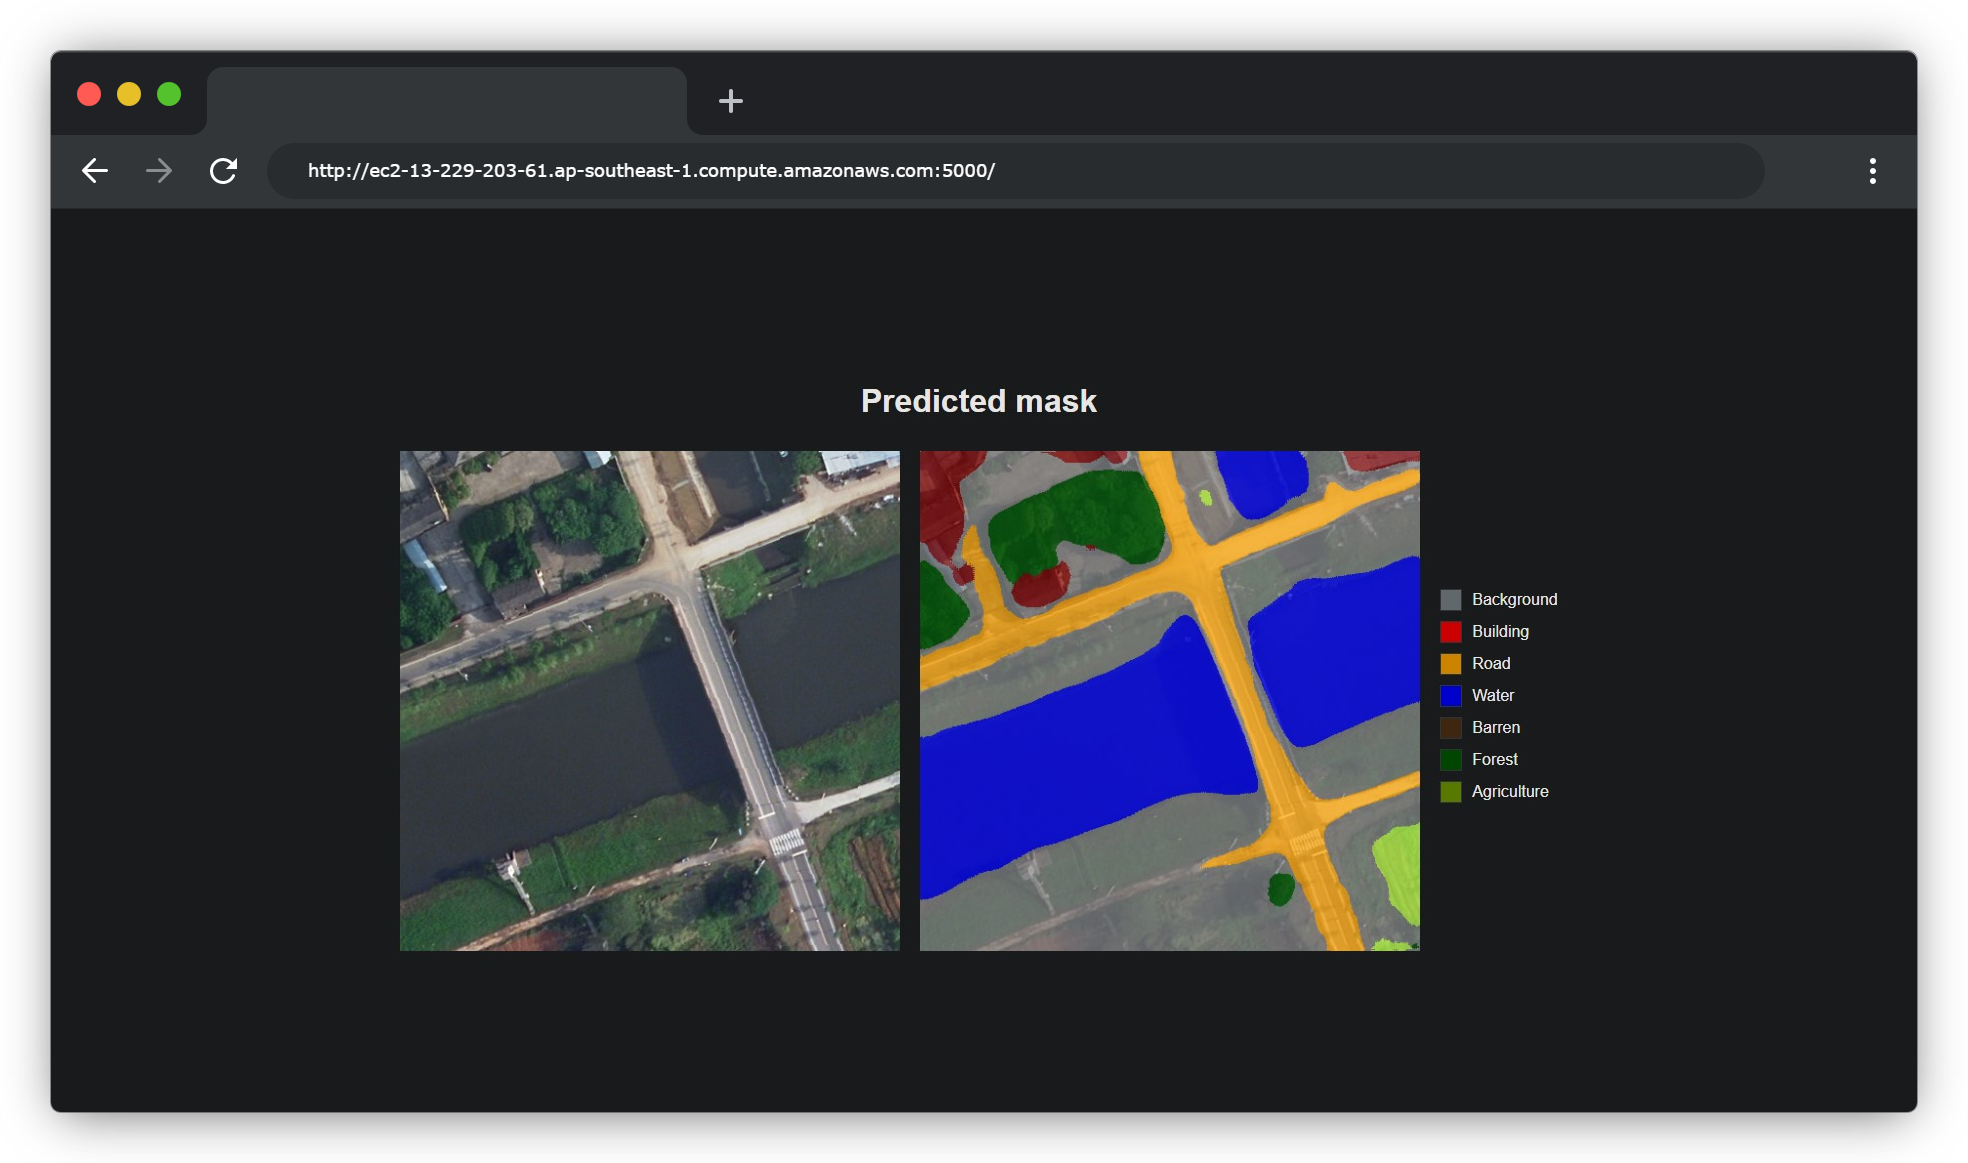

The end-to-end pipeline for satellite image segmentation is composed of the following steps:

1. Data Ingestion
2. Data Preprocessing
3. Model Training
4. Model Evaluation
5. API Inference

## End to End Workflow

The end to end CICD workflow can be summarized below.

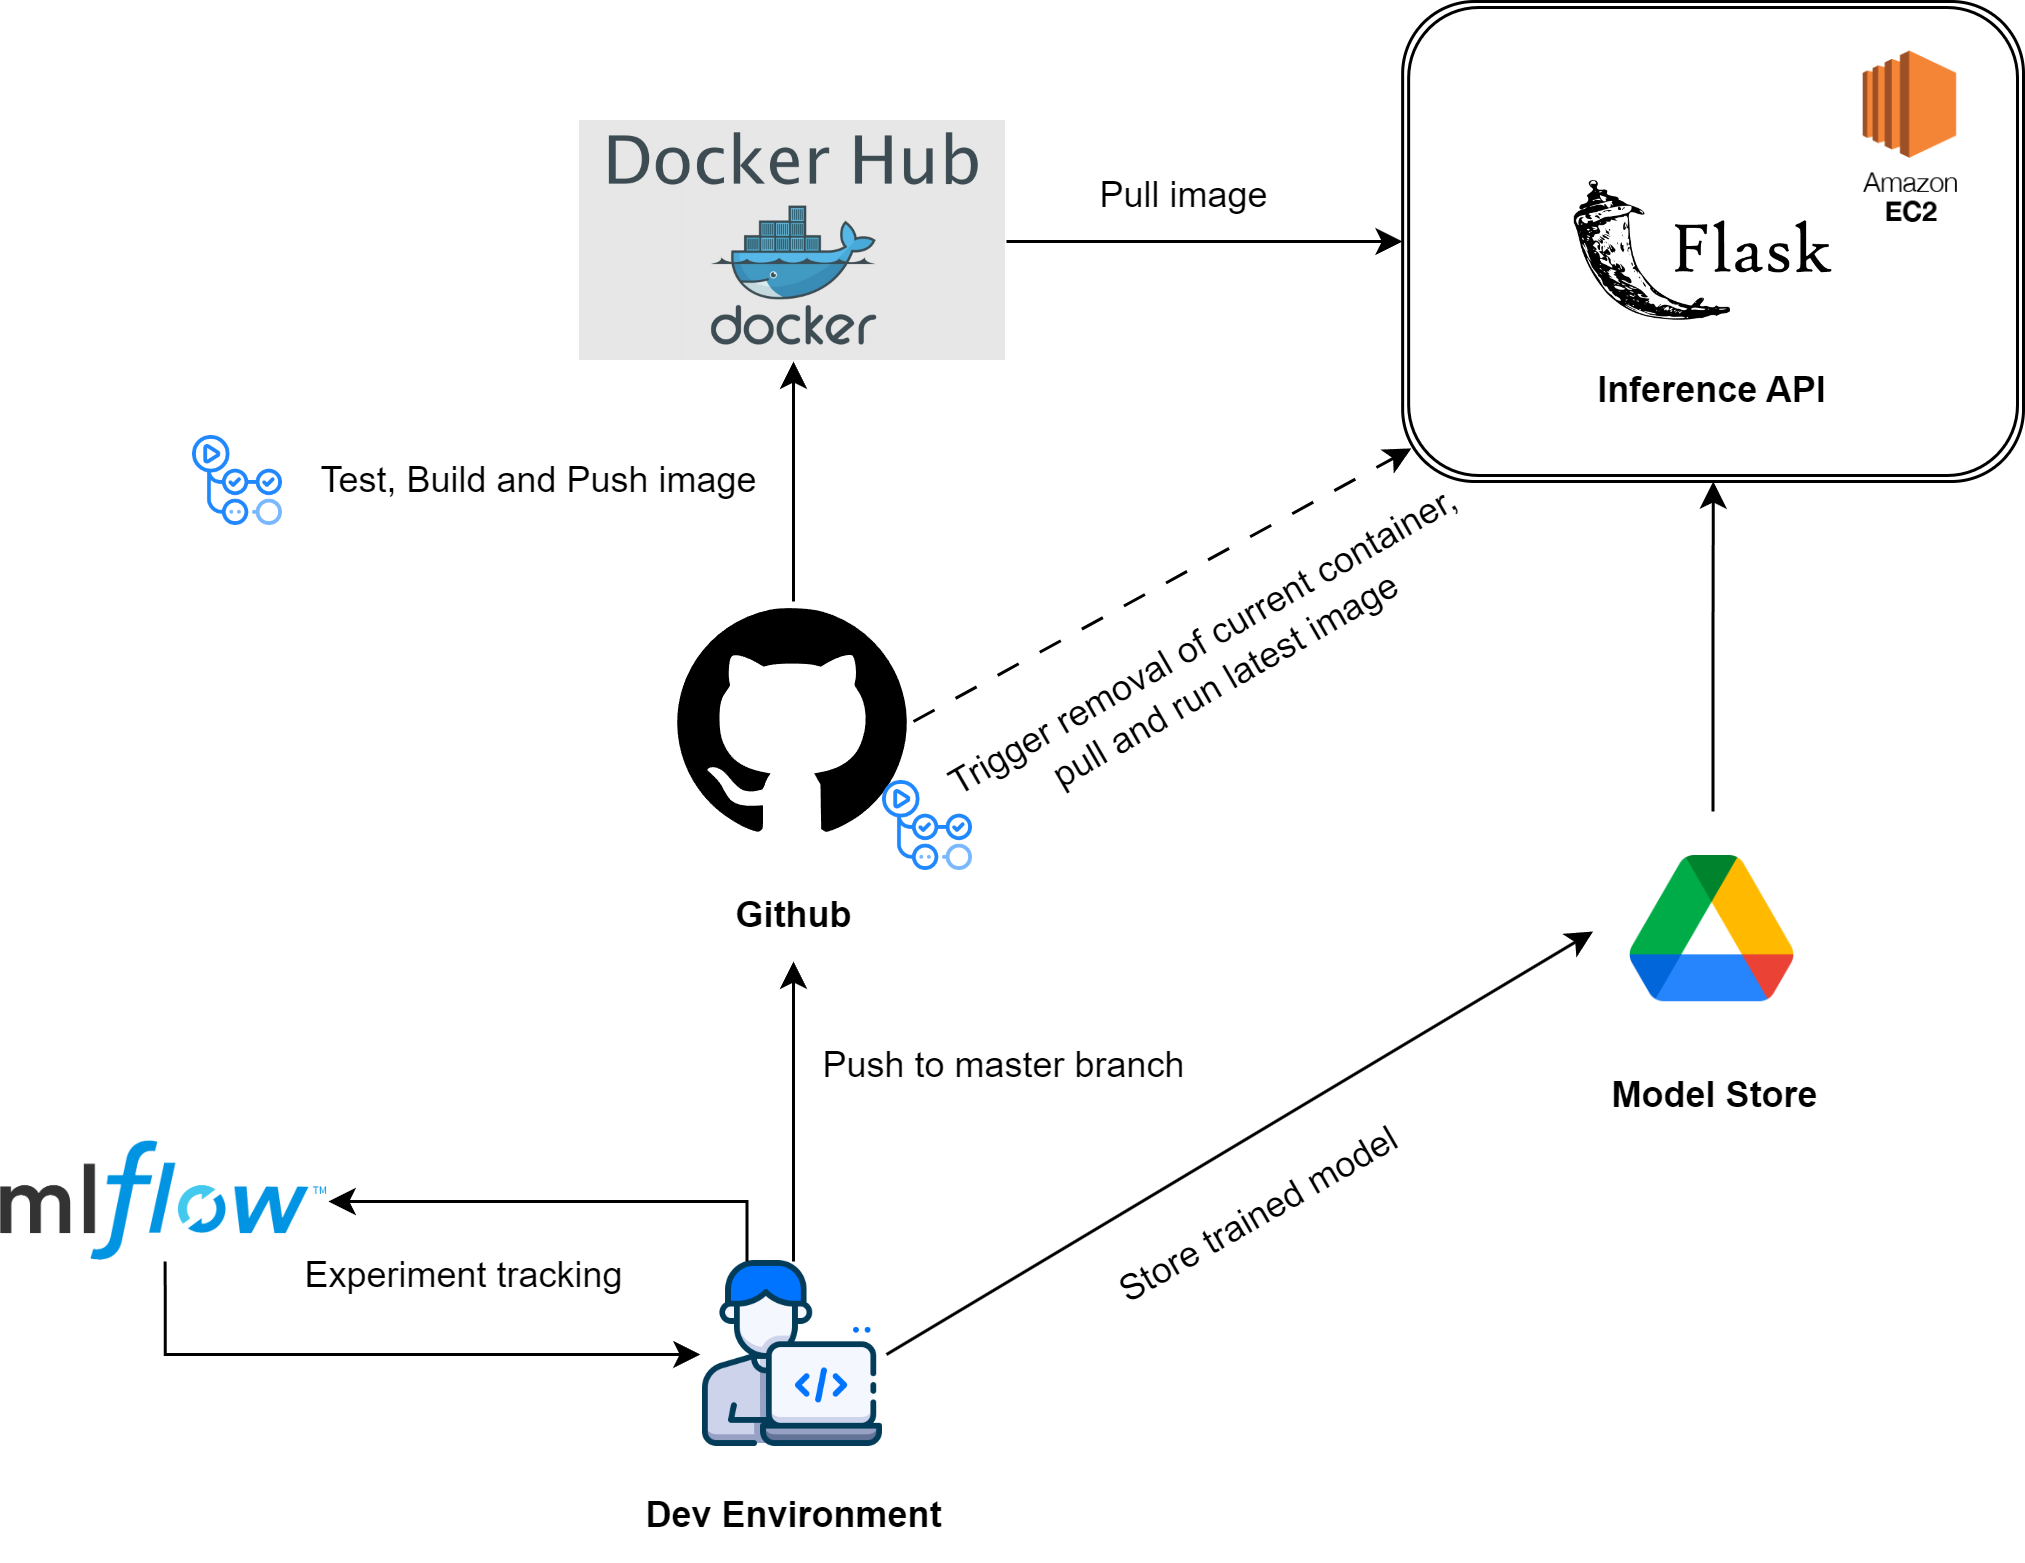

In the development environment, model and hyperparameter tuning experiments are facilitated by the MLFlow tracking server. Once the best model is determined, it is then store in Google Drive. The production ready repo is push to the master branch, which then triggers the Github actions to test, build and push the image to Docker Hub. The Github action then triggers the EC2 instance to pull the latest image from Docker Hub and run the API server. The Flask API server then pulls the best model from Google Drive to perform inferencing.

## Usage

### Model training 

To Train the model locally, run:

```bash
python src/get_and_process_data.py
```
followed by:

```bash
python src/train_model.py
```

Additionally, if you do not have a GPU, a colab notebook is available at `notebooks/train_model.ipynb`. The notebook pulls the repo from Github, runs the ingestion and training pipeline, then saves the model periodically to Google Drive. 

### Model deployment via API

A simple UI can be deployed either locally or on AWS EC2. The UI allows one to upload an image of a satellite and obtain a segmentation mask. 

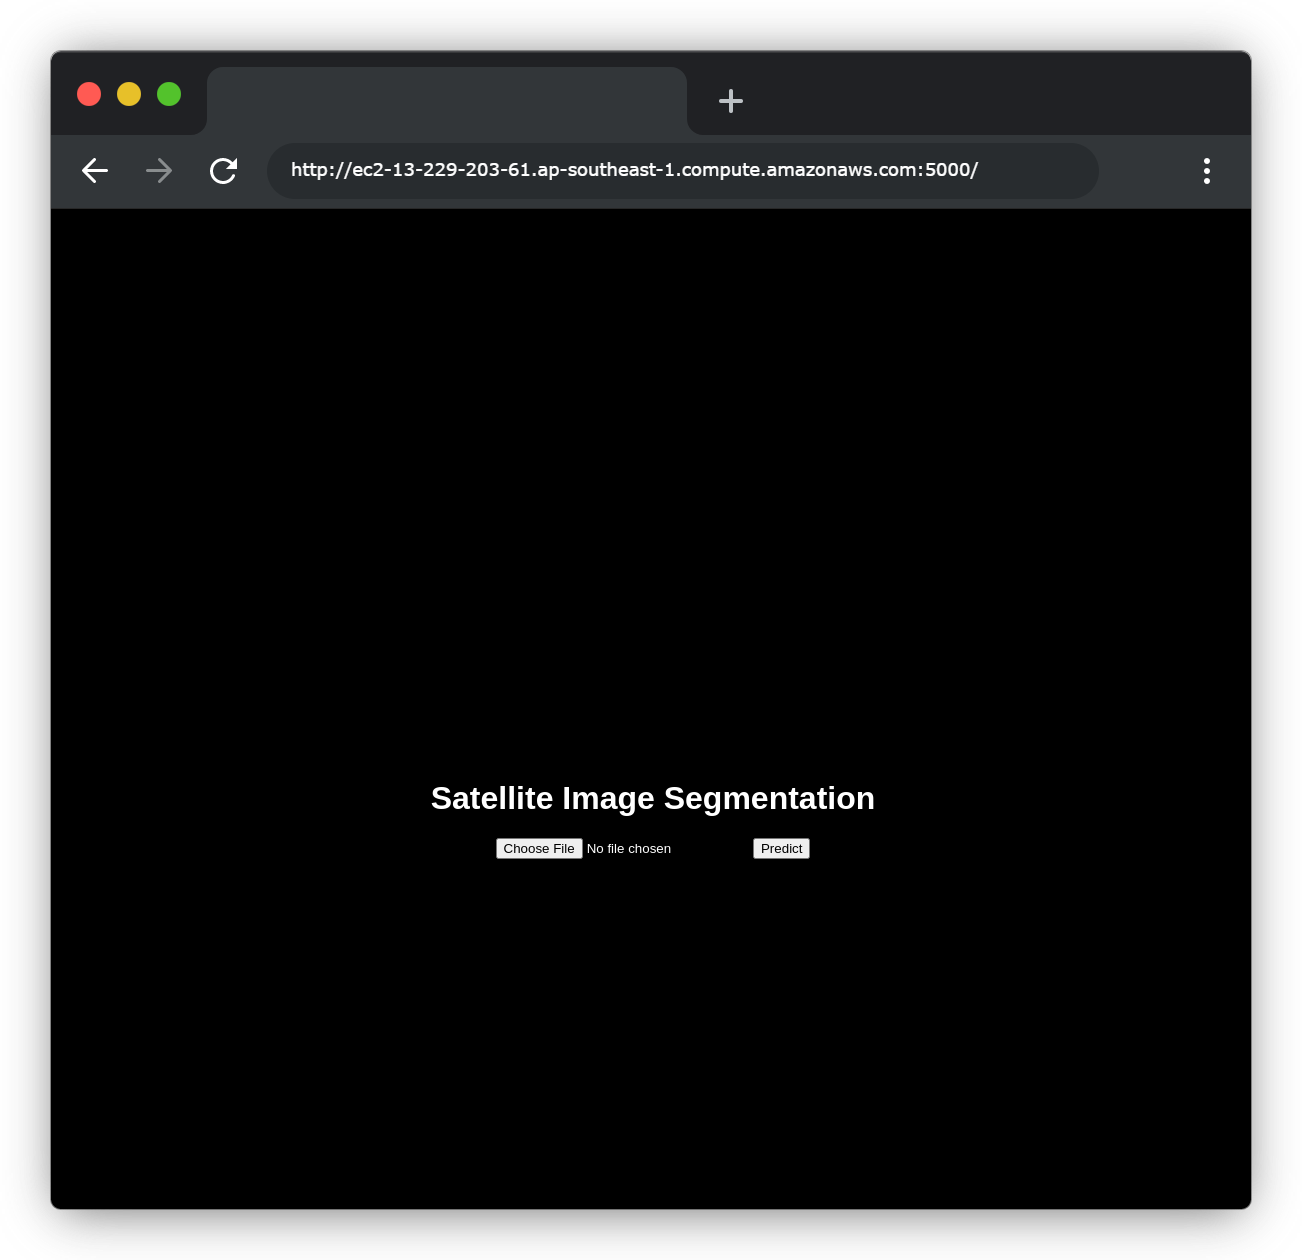

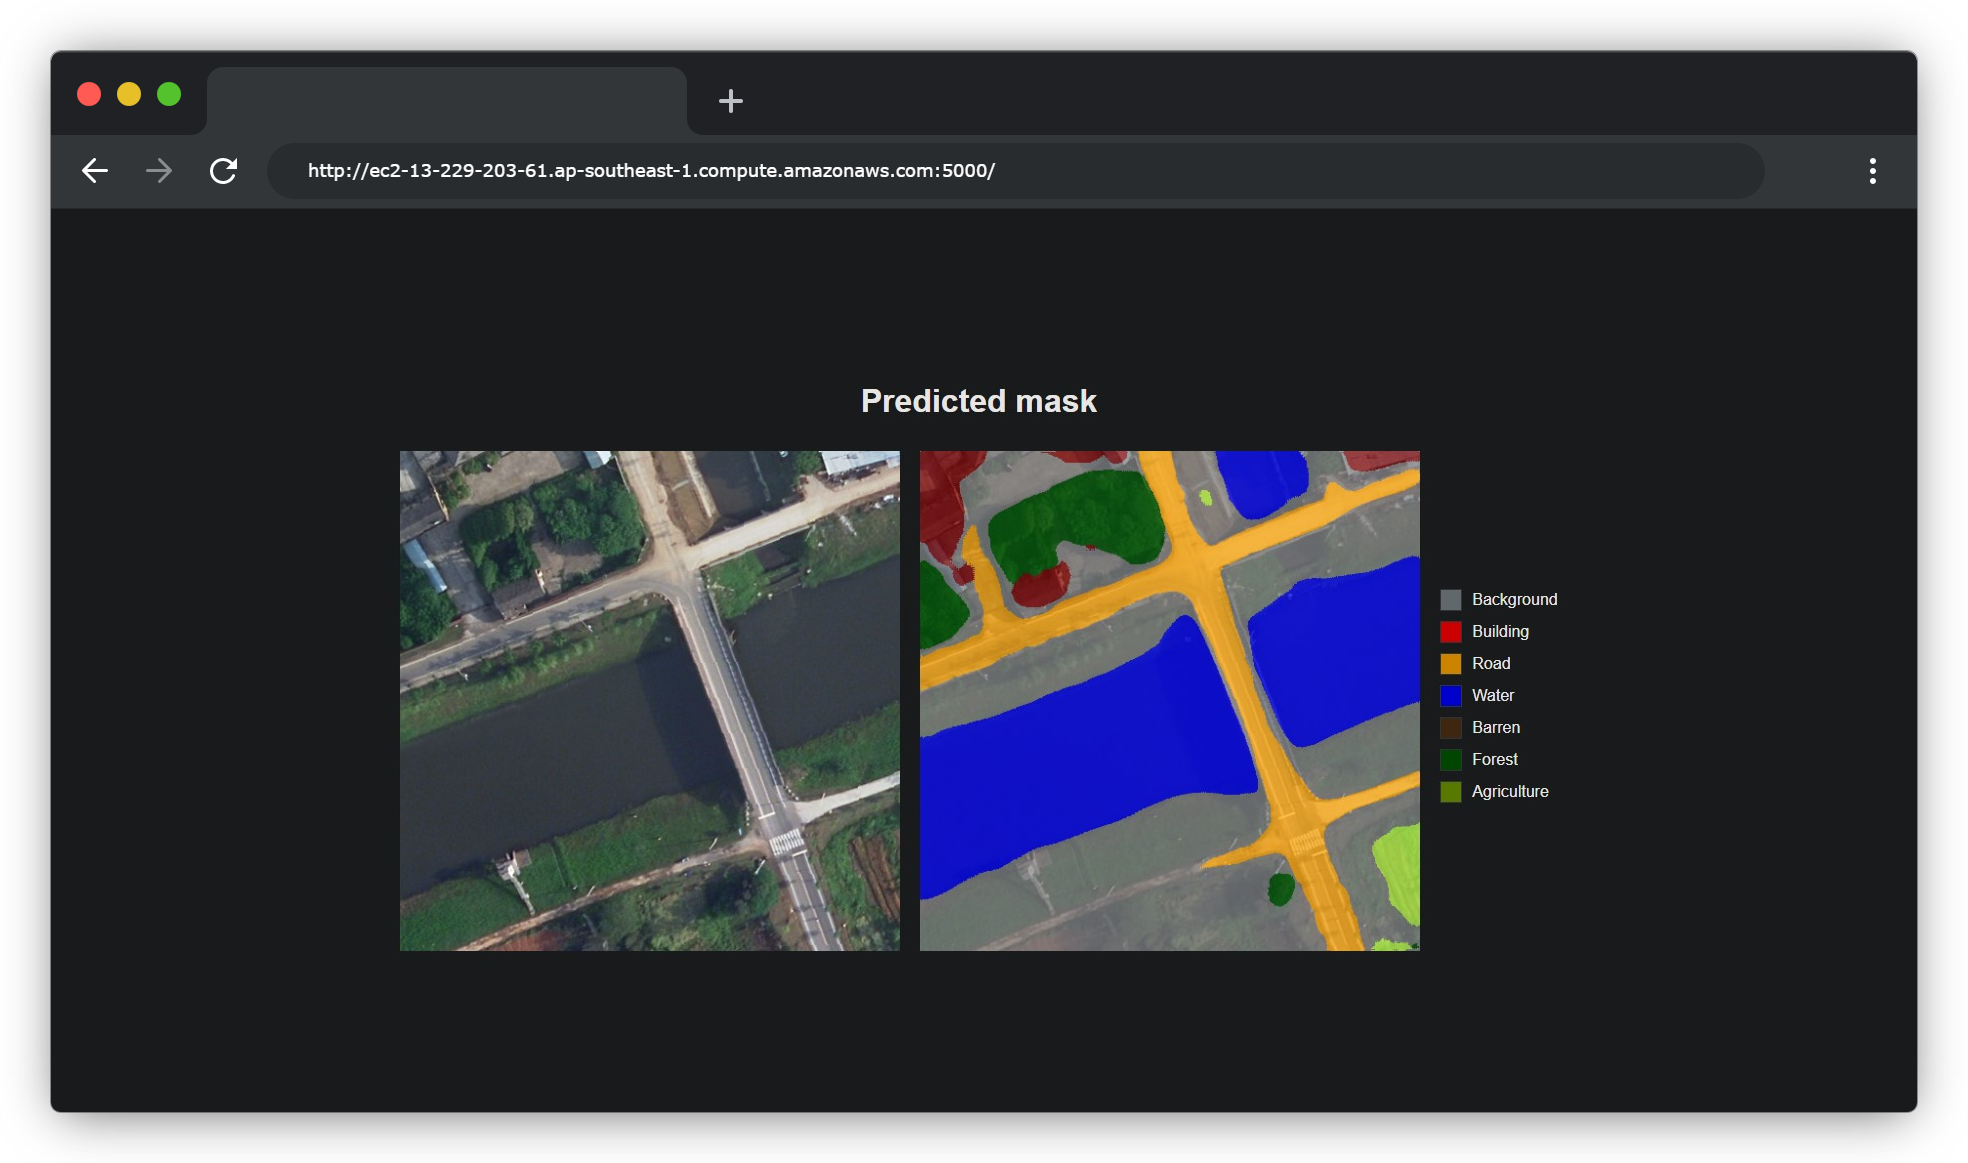

#### Local development environment 

1. Ensure that the `model_path` parameter in `conf/config.yaml` points to the right model path, and model source is set to `local`:


    ```yaml
    api:
      MODEL_PATH: # model path to use for inference
      MODEL_SOURCE: local
    ```

2. Ensure docker is installed on your local machine and service started

3. Build the docker image

    ```bash
    docker build -t sat_img_seg -f .\docker\flask_app.dockerfile .
    ```

4. Run the docker image

    ```bash
    docker run -p 5000:5000 sat_img_seg
    ```

5. The API is now running on `http://localhost:5000/`




#### Model deployment to AWS

A github actions workflow is set up to automatically deploy the API to AWS EC2, whenever the `main` branch is updated.

1. Upload trained model artifact to google drive, and obtain the file id, the file id can be obtained from the shareable link : https://drive.google.com/file/<file_id>/view?usp=drive_link

2. Spin up a EC2 instance on AWS, ensure that docker is installed and service started.

3. Make sure that you have a docker account on docker hub

4. On the Github repo, ensure that the following secrets are set:
    - DOCKER_USERNAME 
    - DOCKER_PASSWORD
    - AWS_HOST (Public IP address of the EC2 instance)
    - AWS_USERNAME (Username of the EC2 instance)
    - AWS_PRIVATE_KEY (Private key of the EC2 instance, you should download a .pem file when you create the EC2 instance, copy and paste the content of the .pem file into the secret)

5. Once a change has been made to the master branch, or manually triggered, the github actions workflow will be triggered, and the API will be deployed to the EC2 instance

5. The API is now running on `http://<AWS_HOST>:5000/`

## Dataset

The dataset consists of 1366 rural and 1156 urban satellite images (1024x1024) and correpsonding masks consisting of remote sensing images from Nanjing, Changzhou, and Wuhan. They are part of the [LoveDA](https://github.com/Junjue-Wang/LoveDA) dataset. 

The original masks contains 8 classes:

    0: unlabelled
    1: background
    2: building
    3: road
    4: water
    5: barren
    6: forest
    7: agriculture

During preprocessing, the unlablled class is removed, which leaves 7 labels.


## Models

Two main model architectures were explored: The original U-Net architecture, and a modified U-Net architecture with a ResNet50 backbone. Blocks in the backbone were selectively unfrozen during training. 